#### Connect ancestors

#### One layer

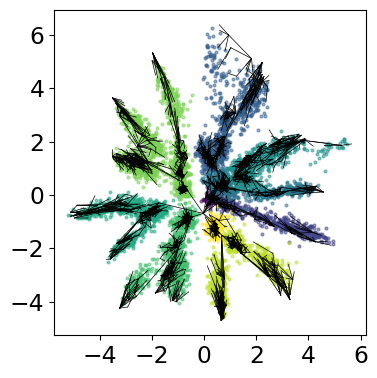

In [12]:
import pickle
from ete3 import Tree
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

# Set font sizes
mpl.rc('font', size=14)
mpl.rc('axes', titlesize='large', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')

def generate_primary_colors(N):
    """Generates N primary colors from the 'viridis' colormap."""
    return cm.viridis(np.linspace(0, 1, N))

def get_subcolors(primary_color, N_subclusters):
    """Generate N_subclusters shades of a primary color."""
    colormap = cm.colors.LinearSegmentedColormap.from_list("custom", [primary_color, (1, 1, 1)], N=N_subclusters)
    return colormap(np.linspace(0.6, 0.1, N_subclusters))

# Load latent space representation
with open("./output/onelayer_n100_weight0.01/latent_space.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']
mu = data['mu']
sigma = data['sigma']

# Create a dictionary to map keys to indices s
key2idx = {key[i]: i for i in range(len(key))}

# Load and process tree
t = Tree("./output/random_tree.newick", format=1)
num_leaf = len(t)
t.name = str(num_leaf)
leaf_idx = []
ancestral_idx = []
for i in range(len(key)):
    if int(key[i]) < num_leaf:
        leaf_idx.append(i)
    else:
        ancestral_idx.append(i)

# Add ancestor and sumdist features to each node
for node in t.traverse('preorder'):
    if node.is_root():
        node.add_feature('anc', [])
        node.add_feature('sumdist', 0)
    else:
        node.add_feature('anc', node.up.anc + [node.up.name])
        node.add_feature('sumdist', node.up.sumdist + node.dist)

# Initial distance cutoff for first layer
dist_cutoff = 0.5
ancestors_dict = {}
firstlayer_head_node_names = []
root = t.get_tree_root()
ancestors_dict[root.name] = []

for node in t.traverse('preorder'):
    if node.is_leaf() and node.sumdist < dist_cutoff:
        firstlayer_head_node_names.append(node.name)
    if (not node.is_leaf()) and node.sumdist > dist_cutoff and node.up.sumdist < dist_cutoff:
        firstlayer_head_node_names.append(node.name)
        ancestors_dict[root.name].append(node.name)

# Collect extant sequences for major clusters
cluster_node_names = {}
for name in firstlayer_head_node_names:
    cluster_node_names[name] = []
    for node in (t & name).traverse('preorder'):
        cluster_node_names[name].append(node.name)

# Number of major clusters at the distance cutoff = 0.5
colors = generate_primary_colors(len(firstlayer_head_node_names))  # Generate a color for each cluster

fig, ax = plt.subplots(figsize=(4, 4))
for i in range(len(firstlayer_head_node_names)):
    names = cluster_node_names[firstlayer_head_node_names[i]]
    # Only plot the extant sequences
    idx = [key2idx[n] for n in names if int(n) <= 9999]
    ax.plot(mu[idx,0], mu[idx,1], '.', c=colors[i], markersize = 4, label = firstlayer_head_node_names[i], alpha=0.5)

# Generate colors for major clusters
colors = generate_primary_colors(len(firstlayer_head_node_names))

# Define the cutoffs and initialize layer head node lists
cutoffs = [1.0, 1.5, 2.0, 2.5, 3.0]
layer_head_node_names = [firstlayer_head_node_names]

# Iterate through each cutoff to dynamically create subclusters for each layer
for dist_cutoff in cutoffs:
    current_layer_head_node_names = []
    for branch in layer_head_node_names[-1]:  # Use the head nodes from the previous layer
        sub_t = t & branch
        ancestors_dict[branch] = []
        
        for node in sub_t.traverse('preorder'):
            if (not node.is_leaf()) and node.sumdist > dist_cutoff and node.up.sumdist < dist_cutoff:
                current_layer_head_node_names.append(node.name)
                ancestors_dict[branch].append(node.name)
    
    # Append the current layer's head nodes to the list of layers
    layer_head_node_names.append(current_layer_head_node_names)

# Draw connections for ancestors to descendents
for ancestor, descendants in ancestors_dict.items():
    ancestor_idx = key2idx[ancestor]
    for descendant in descendants:
        descendant_idx = key2idx[descendant]
        ax.plot([mu[ancestor_idx, 0], mu[descendant_idx, 0]], 
                 [mu[ancestor_idx, 1], mu[descendant_idx, 1]], 
                 color='k', linestyle='-', linewidth=0.5)

# Set labels and legend for the plot
# ax.set_xlabel(r'$Z_1$')
# ax.set_ylabel(r'$Z_2$')

# Set the tick positions
ax.set_xticks(np.arange(-4, 7, 2))
ax.set_yticks(np.arange(-4, 7, 2))

# Hide the tick labels
# ax.set_xticklabels([''] * len(np.arange(-4, 7, 2)))
# ax.set_yticklabels([''] * len(np.arange(-4, 7, 2)))

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("/home/cdchiang/vae/PF01494/latent_space/simulated_msa/output/onelayer_n100_weight0.01/connected_ancestors.png", dpi=300, format='png')
plt.show()

#### Two layer

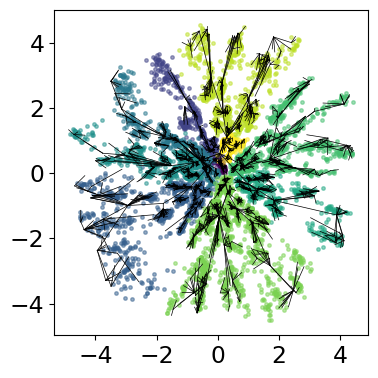

In [13]:
import pickle
from ete3 import Tree
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt

# Set font sizes
mpl.rc('font', size=14)
mpl.rc('axes', titlesize='large', labelsize='large')
mpl.rc('xtick', labelsize='large')
mpl.rc('ytick', labelsize='large')

def generate_primary_colors(N):
    """Generates N primary colors from the 'viridis' colormap."""
    return cm.viridis(np.linspace(0, 1, N))

def get_subcolors(primary_color, N_subclusters):
    """Generate N_subclusters shades of a primary color."""
    colormap = cm.colors.LinearSegmentedColormap.from_list("custom", [primary_color, (1, 1, 1)], N=N_subclusters)
    return colormap(np.linspace(0.6, 0.1, N_subclusters))

# Load latent space representation
with open("./output/twolayer_n100_500_weight0.01/latent_space.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
key = data['key']
mu = data['mu']
sigma = data['sigma']

# Create a dictionary to map keys to indices
key2idx = {key[i]: i for i in range(len(key))}

# Load and process tree
t = Tree("./output/random_tree.newick", format=1)
num_leaf = len(t)
t.name = str(num_leaf)
leaf_idx = []
ancestral_idx = []
for i in range(len(key)):
    if int(key[i]) < num_leaf:
        leaf_idx.append(i)
    else:
        ancestral_idx.append(i)

# Add ancestor and sumdist features to each node
for node in t.traverse('preorder'):
    if node.is_root():
        node.add_feature('anc', [])
        node.add_feature('sumdist', 0)
    else:
        node.add_feature('anc', node.up.anc + [node.up.name])
        node.add_feature('sumdist', node.up.sumdist + node.dist)

# Initial distance cutoff for first layer
dist_cutoff = 0.5
ancestors_dict = {}
firstlayer_head_node_names = []
root = t.get_tree_root()
ancestors_dict[root.name] = []

for node in t.traverse('preorder'):
    if node.is_leaf() and node.sumdist < dist_cutoff:
        firstlayer_head_node_names.append(node.name)
    if (not node.is_leaf()) and node.sumdist > dist_cutoff and node.up.sumdist < dist_cutoff:
        firstlayer_head_node_names.append(node.name)
        ancestors_dict[root.name].append(node.name)

# Collect extant sequences for major clusters
cluster_node_names = {}
for name in firstlayer_head_node_names:
    cluster_node_names[name] = []
    for node in (t & name).traverse('preorder'):
        cluster_node_names[name].append(node.name)

# Number of major clusters at the distance cutoff = 0.5
colors = generate_primary_colors(len(firstlayer_head_node_names))  # Generate a color for each cluster

fig, ax = plt.subplots(figsize=(4, 4))
for i in range(len(firstlayer_head_node_names)):
    names = cluster_node_names[firstlayer_head_node_names[i]]
    # Only plot the extant sequences
    idx = [key2idx[n] for n in names if int(n) <= 9999]
    ax.plot(mu[idx,0], mu[idx,1], '.', c=colors[i], markersize = 5, label = firstlayer_head_node_names[i], alpha=0.5)

# Generate colors for major clusters
colors = generate_primary_colors(len(firstlayer_head_node_names))

# Define the cutoffs and initialize layer head node lists
cutoffs = [1.0, 1.5, 2.0, 2.5, 3.0]
layer_head_node_names = [firstlayer_head_node_names]

# Iterate through each cutoff to dynamically create subclusters for each layer
for dist_cutoff in cutoffs:
    current_layer_head_node_names = []
    for branch in layer_head_node_names[-1]:  # Use the head nodes from the previous layer
        sub_t = t & branch
        ancestors_dict[branch] = []
        
        for node in sub_t.traverse('preorder'):
            if (not node.is_leaf()) and node.sumdist > dist_cutoff and node.up.sumdist < dist_cutoff:
                current_layer_head_node_names.append(node.name)
                ancestors_dict[branch].append(node.name)
    
    # Append the current layer's head nodes to the list of layers
    layer_head_node_names.append(current_layer_head_node_names)

# Draw connections for ancestors to descendents
for ancestor, descendants in ancestors_dict.items():
    ancestor_idx = key2idx[ancestor]
    for descendant in descendants:
        descendant_idx = key2idx[descendant]
        ax.plot([mu[ancestor_idx, 0], mu[descendant_idx, 0]], 
                 [mu[ancestor_idx, 1], mu[descendant_idx, 1]], 
                 color='k', linestyle='-', linewidth=0.5)

# Set labels and legend for the plot
# ax.set_xlabel(r'$Z_1$')
# ax.set_ylabel(r'$Z_2$')

# Set the tick positions
ax.set_xticks(np.arange(-4, 5, 2))
ax.set_yticks(np.arange(-4, 5, 2))

# Hide the tick labels
# ax.set_xticklabels([''] * len(np.arange(-4, 5, 2)))
# ax.set_yticklabels([''] * len(np.arange(-4, 5, 2)))

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("/home/cdchiang/vae/PF01494/latent_space/simulated_msa/output/twolayer_n100_500_weight0.01/connected_ancestors.png", dpi=300, format='png')
plt.show()
